In [3]:
### FIX LINK FOR FUNCTIONS WHEN PUSH TO MASTER ###

In [1]:
import sys
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from trump import load, treat, text

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

plots_args = {'fontsize': 14, 'color': '#9370DB'}

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = load.load_tweets()

check function [load_tweets](https://github.com/liabifano/project/blob/master/trump/src/trump/load.py#L16)

In [3]:
df['clean_tokens'], df['clean_text'] = text.clean_series(df['text'])

check function [clean_series](https://github.com/liabifano/project/blob/master/trump/src/trump/text.py)

# Writing Style

### Over time

In [4]:
def plot_interval_by_cohort(df, cohort, metric, color):
    agg = (df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]
           .sort_values('first_day_month_cohort')
           .groupby(cohort).describe()[metric])
    
    agg['lower_bound'] = agg['mean'] - 2*agg['std'] / np.sqrt(agg['count'])
    agg['upper_bound'] = agg['mean'] + 2*agg['std'] / np.sqrt(agg['count'])
    
    agg['lower_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['upper_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['mean'].plot(linestyle='-', linewidth=3, color=c, legend=True, fontsize=14);
    
    plt.title('Writing style by Quarter'.format(metric), fontsize=20); 
    plt.xlabel('Time', fontsize=16); plt.ylabel('Mean', fontsize=16);
    plt.legend(metric, fontsize=14)
    plt.ylim([0,1.2])
    plt.plot()

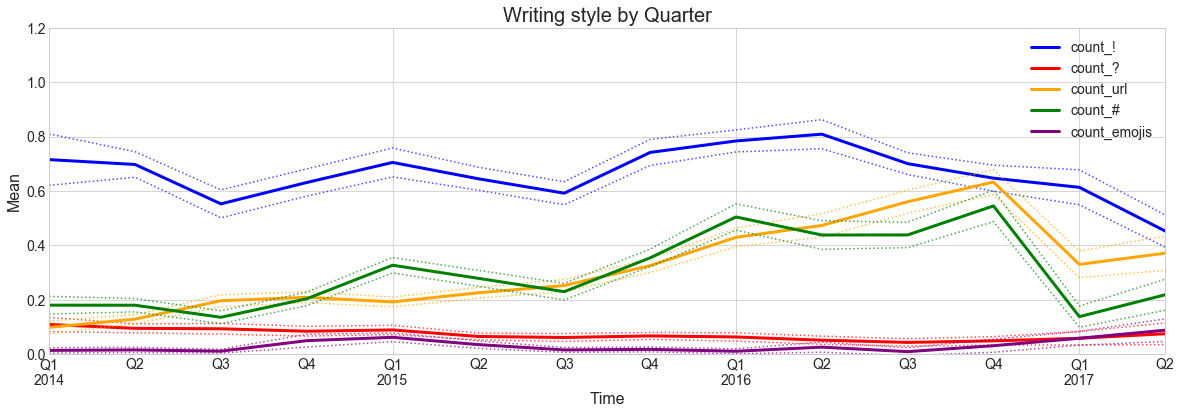

In [5]:
metric_writing_style = [('count_!', 'blue'),
                        ('count_?', 'red'), 
                        ('count_url', 'orange'),
                        ('count_#', 'green'),
                        ('count_emojis', 'purple')]
plt.figure(figsize=(20,6))
for m, c in metric_writing_style:
    plot_interval_by_cohort(df, 'quarter_cohort', m, c)
plt.legend(list(map(lambda x: x[0], metric_writing_style)), loc=1, fontsize=14);

In [6]:
tags = text.count_tags(df['clean_tokens'])
df = pd.concat([df, tags], axis=1)

check [count_tags]()

In [7]:
df = text.get_hardcoded_subjects(df)
subjects = ['hillary', 'obama', 'make_america', 'war', 'democra']

Number of tweets with hillary: 987 (3.2 %)


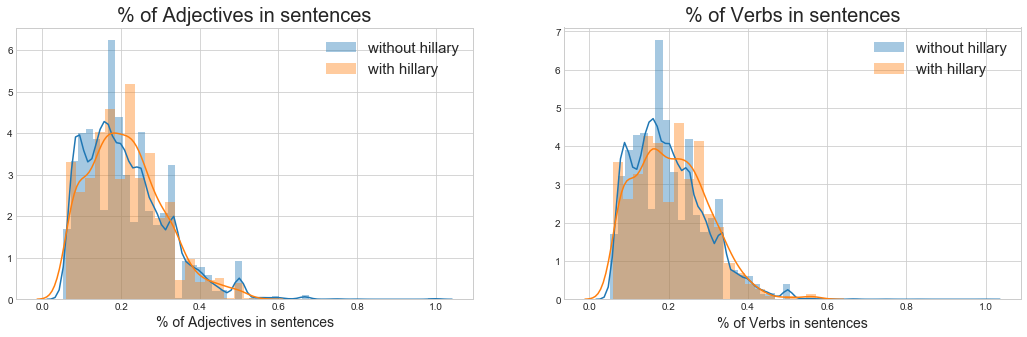

Number of tweets with obama: 2540 (8.1 %)


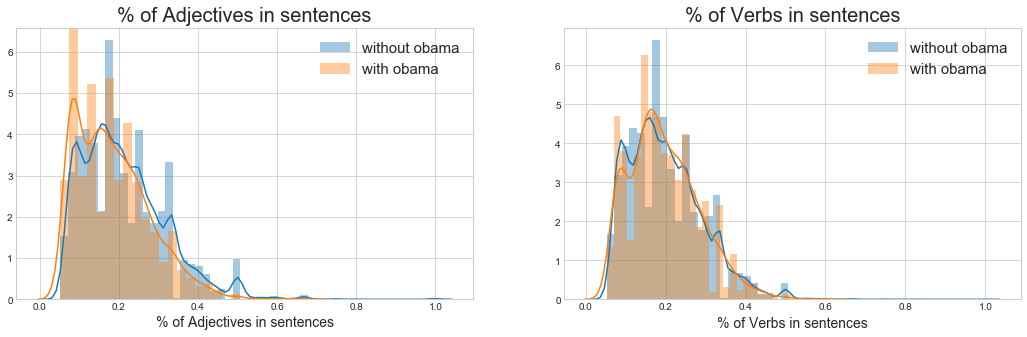

Number of tweets with make_america: 1070 (3.4 %)


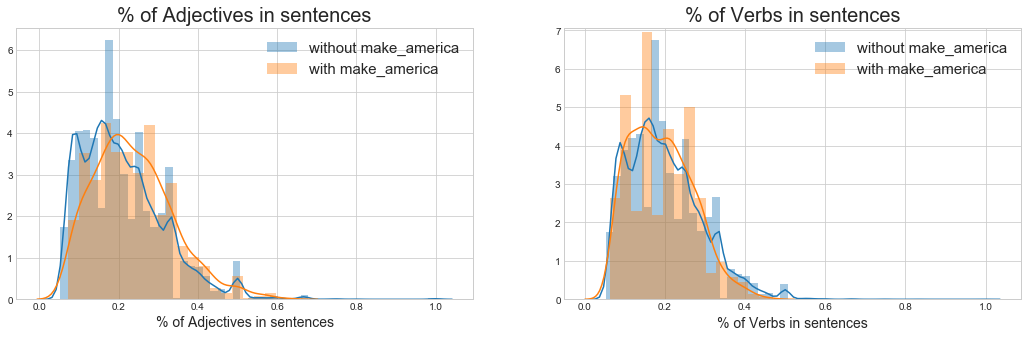

Number of tweets with war: 1165 (3.7 %)


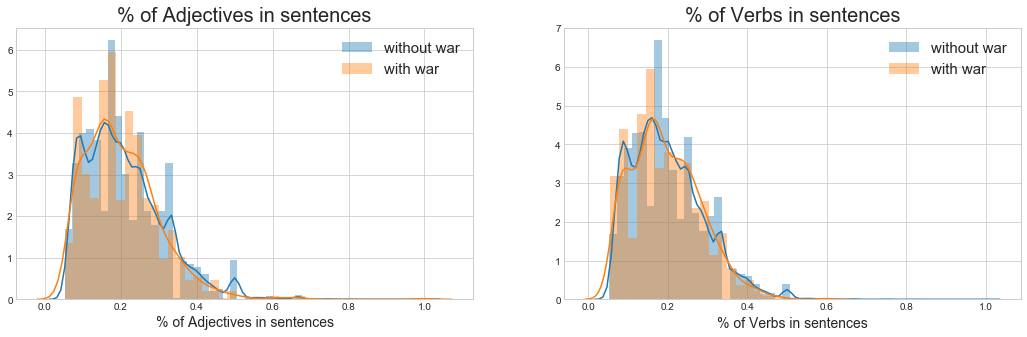

Number of tweets with democra: 218 (0.7 %)


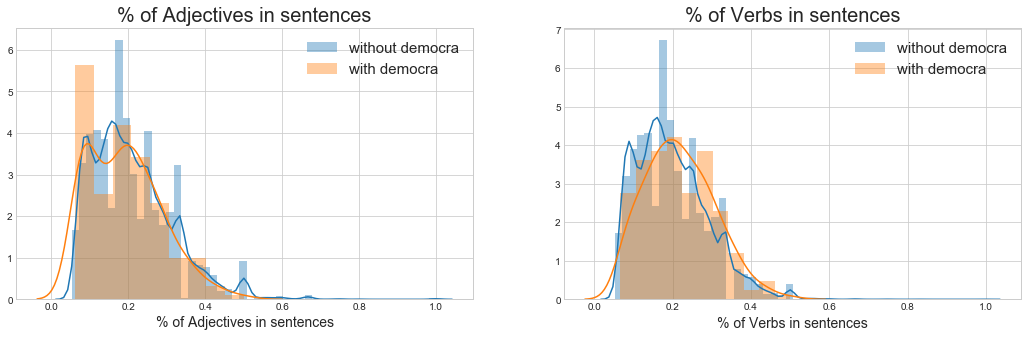

In [17]:
for sub in subjects:
    print('Number of tweets with {}: {} ({} %)'.format(sub, df[sub].sum(), round(100*df[sub].sum()/len(df), 1)))

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    filtered = df[df['prop_adj'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_adj'], ax=ax[0]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_adj'], ax=ax[0]);
    ax[0].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);
    ax[0].set_xlabel("% of Adjectives in sentences", fontsize=14)
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);

    filtered = df[df['prop_verbs'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_verbs'], ax=ax[1]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_verbs'], ax=ax[1]);
    ax[1].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[1].set_xlabel("% of Verbs in sentences", fontsize=14)
    ax[1].set_title('% of Verbs in sentences', fontsize=20);
    
    plt.show()

### by Device

Out-of-bag score: 69.8%


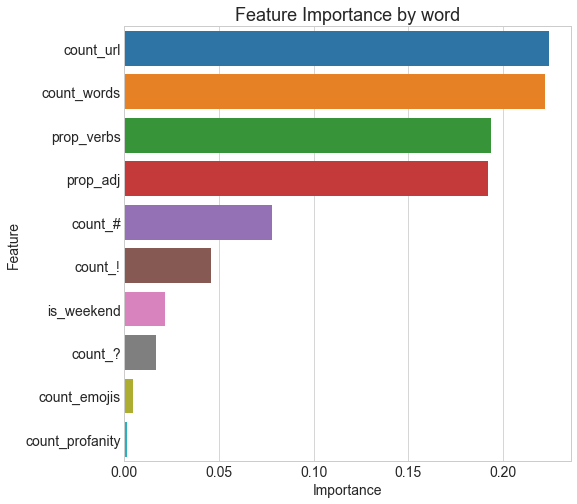

In [9]:
from sklearn.ensemble import RandomForestClassifier

valid_devices = ['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android']
features = ['is_weekend', 'count_url','count_!', 'count_?', 'count_#', 
            'count_words', 'count_emojis', 'count_profanity', 'prop_adj', 
            'prop_verbs']
df_channels = df[(df['source'].apply(lambda x: x in valid_devices)) & 
                 (df['first_day_month_cohort'] > datetime(2016,1,1)) & 
                 (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

def plot_importance_rf(df, features, label):
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=189, 
                                 oob_score=True)
    clf.fit(df[features], df[label]);

    importances = clf.feature_importances_
    feat_importance = (pd.DataFrame(list(zip(features, importances)), 
                               columns=['feature', 'importance'])
                  .sort_values('importance', ascending=False))
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y='feature', x='importance', 
                     data=feat_importance,
                     saturation=0.8)
    ax.set_title('Feature Importance by word', fontsize=18)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Importance', fontsize=14); plt.ylabel('Feature', fontsize=14);
    print('Out-of-bag score: {s}%'.format(s=100*round(clf.oob_score_, 3)));
    ax;
    
plot_importance_rf(df_channels, features, 'source')

In [ ]:
# put a chart of how url and count change by channel